# 20217137 강슬기

In [1]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset

import re
import os
import cv2
import timm
import random
import numpy as np
import pandas as pd
import time
%matplotlib inline
import matplotlib.pyplot as plt

from glob import glob
from PIL import Image
from tqdm import tqdm # 학습 진행률 파악을 위해 tqdm 라이브러리 추가

In [2]:
def set_seed(seed=22):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

# seed 고정
set_seed(22)

# GPU 사용 설정
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    device = 'cpu'
    print('CUDA is not available.  Training on CPU ...')
else:
    device = 'cuda'
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_root = '/content/drive/MyDrive/data/ipdl/train/Real'

file_count = len([file for file in os.listdir(data_root) if os.path.isfile(os.path.join(data_root, file))])

print(f" 파일 개수: {file_count}")


 파일 개수: 2500


In [5]:
# Kaggle 이외의 환경에서 사용
file_path = '/content/drive/MyDrive/data/ipdl/train/*/*.jpg'

file_list = glob(file_path)
data_dict = {'image_name':[], 'class':[], 'target':[], 'file_path':[]}
target_dict = {'Real':0, 'Fake':1}

for path in file_list:

    data_dict['file_path'].append(path) # file_path 항목에 파일 경로 저장

    path_list = path.split(os.path.sep) # os별 파일 경로 구분 문자로 split
    # print(path_list)

    data_dict['image_name'].append(path_list[-1])
    data_dict['class'].append(path_list[-2])
    data_dict['target'].append(target_dict[path_list[-2]])

train_df = pd.DataFrame(data_dict)
print('\n<data frame>\n', train_df)

train_df.to_csv("./train.csv", mode='w')


<data frame>
         image_name class  target  \
0       pckrmp.jpg  Fake       1   
1     pconixes.jpg  Fake       1   
2      pdajynr.jpg  Fake       1   
3     pddvfooz.jpg  Fake       1   
4      pdlzieo.jpg  Fake       1   
...            ...   ...     ...   
4995   ffmbhov.jpg  Real       0   
4996   ffvysux.jpg  Real       0   
4997   fglxvyn.jpg  Real       0   
4998  fgsyggbj.jpg  Real       0   
4999     fhfbb.jpg  Real       0   

                                              file_path  
0     /content/drive/MyDrive/data/ipdl/train/Fake/pc...  
1     /content/drive/MyDrive/data/ipdl/train/Fake/pc...  
2     /content/drive/MyDrive/data/ipdl/train/Fake/pd...  
3     /content/drive/MyDrive/data/ipdl/train/Fake/pd...  
4     /content/drive/MyDrive/data/ipdl/train/Fake/pd...  
...                                                 ...  
4995  /content/drive/MyDrive/data/ipdl/train/Real/ff...  
4996  /content/drive/MyDrive/data/ipdl/train/Real/ff...  
4997  /content/drive/MyDrive/d

In [7]:
class MMC_ClassificationDataset(Dataset):
    def __init__(self, csv, mode, transform=None):
        self.csv = pd.read_csv(csv)
        self.csv = self.csv.reset_index(drop=True)
        self.mode = mode # train / valid
        self.transform = transform

    def __len__(self):
        return self.csv.shape[0]

    def __getitem__(self, index):
        row = self.csv.iloc[index]
        image = cv2.imread(row.file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # 이미지 tranform 적용
        if self.transform is not None:
            res = self.transform(image=image)
            image = res['image'].astype(np.float32)
        else:
            image = image.astype(np.float32)

        image = image.transpose(2, 0, 1)

        data = torch.tensor(image).float()

        if self.mode == 'test':
            return data, row['image_name']
        else:
            target = torch.tensor(row['target'])
            return data, target


In [8]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
import albumentations

# 본인의 학습 전략에 맞는 transform 사용
# https://albumentations.ai/docs/examples/example/
# https://albumentations.ai/docs/api_reference/full_reference/

# 초기 transform
# transforms_train = albumentations.Compose([
#         albumentations.HorizontalFlip(p=0.5),
#         albumentations.Resize(224, 224),
#         albumentations.Rotate(limit=30, p=0.5),
#         albumentations.RandomRain(p=0.5),
#         albumentations.RandomShadow(p=0.5),
#         albumentations.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
#         albumentations.ISONoise(color_shift=(0.01, 0.05), intensity=(0.1, 0.5), p=0.5),
#         albumentations.MotionBlur(blur_limit=3, p=0.3),
#         albumentations.Normalize(),
# ])

# 학습에 사용된 transform
transforms_train = albumentations.Compose([
        albumentations.HorizontalFlip(p=0.5),
        albumentations.Resize(224, 224),
        albumentations.Rotate(limit=30, p=0.5),
        albumentations.RandomShadow(p=0.5),
        albumentations.GaussNoise(var_limit=(10.0, 50.0), p=0.7),
        albumentations.Normalize(),
])


transforms_val = albumentations.Compose([
        albumentations.Resize(224, 224),
        albumentations.Normalize()
])

train_data = MMC_ClassificationDataset('/content/train.csv', 'train', transform = transforms_train)

train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_dataset, validation_dataset = torch.utils.data.random_split(train_data, [train_size, val_size])
validation_dataset.transform = transforms_val

In [9]:
batch_size  = 50
num_workers = 6
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, num_workers = num_workers, shuffle = True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = batch_size, num_workers = num_workers)


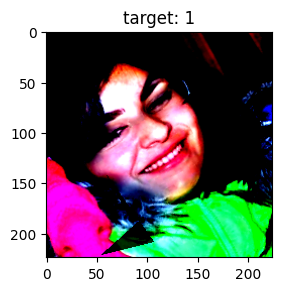

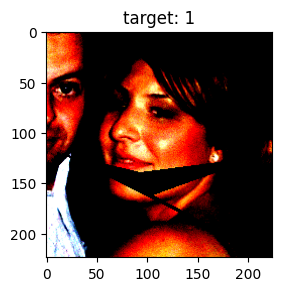

In [10]:
# 데이터셋 확인
for i in range(2):
    d1 = train_data[i]
    plt.subplot(1,2,1)
    plt.imshow(torch.squeeze(d1[0]).numpy().transpose(1,2,0))
    plt.title('target: ' + str(d1[1].item()))
    plt.show()

In [11]:
timm.list_models()


['bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_large_patch16_224',
 'botnet26t_256',
 'botnet50ts_256',
 'caformer_b36',
 'caformer_m36',
 'caformer_s18',
 'caformer_s36',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_medium',
 'coat_lite_medium_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_small',
 'coat_tiny',
 'coatnet_0_224',
 'coatnet_0_rw_224',
 'coatnet_1_224',
 'coatnet_1_rw_224',
 'coatnet_2_224',
 'coatnet_2_rw_224',
 'coatnet_3_224',
 'coatnet_3_rw_224',
 'coatnet_4_224',
 'coatnet_5_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_cc_224',
 'coatnet_nano_rw_224',
 'coatnet_pico_rw_224',
 'coatnet_rmlp_0_rw_224',
 'coatnet_rmlp_1_rw2_224',
 'coatnet_rmlp_1_r

In [ ]:
# Resnet
class Pretrained_model(nn.Module):
    def __init__(self, out_dim, pretrained=True):
        super(Pretrained_model, self).__init__()

        # resnet18 모델
        # https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html
        self.enet = model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

        # timm 라이브러리에서는 다양한 모델을 손쉽게 사용할 수 있음
        # https://timm.fast.ai/

        # timm에서 지원하는 모델 목록
        # timm.list_models()

        # ImageNet dataset 기준 State Of The Art(SOTA) model
        # https://paperswithcode.com/sota/image-classification-on-imagenet

        # # 모델 파라메터 고정
        # for param in self.enet.parameters():
        #     param.requires_grad = False

        in_ch = self.enet.fc.in_features
        self.myfc = nn.Linear(in_ch, out_dim)
        self.enet.fc = nn.Identity()

    def extract(self, x):
        x = self.enet(x)
        return x

    def forward(self, x, x_meta=None):
        x = self.extract(x)
        out = self.myfc(x)
        return out

In [12]:
# EfficientNet

class Pretrained_model(nn.Module):
    def __init__(self, out_dim, pretrained=True):
        super(Pretrained_model, self).__init__()

        self.enet = model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        in_ch = self.enet.classifier[1].in_features
        self.enet.classifier = nn.Linear(in_ch, out_dim)

    def forward(self, x, x_meta=None):
        x = self.enet(x)
        return x

In [ ]:
# ViT
class Pretrained_model(nn.Module):
    def __init__(self, out_dim, pretrained=True):
        super(Pretrained_model, self).__init__()
        # https://pytorch.org/vision/main/models/generated/torchvision.models.vit_b_16.html#torchvision.models.vit_b_16

        self.enet = model = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT)
        in_ch = self.enet.heads.head.in_features
        self.enet.heads.head = nn.Linear(in_ch, out_dim)

    def forward(self, x, x_meta=None):
        x = self.enet(x)
        return x

In [ ]:
# VGG
class Pretrained_model(nn.Module):
    def __init__(self, out_dim, pretrained=True):
        super(Pretrained_model, self).__init__()

        self.enet = model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

        in_ch = self.enet.classifier[6].in_features
        self.enet.classifier[6] = nn.Linear(in_ch, out_dim)

    def forward(self, x, x_meta=None):
        x = self.enet(x)
        return x

In [ ]:
# efficientnet_v2_s
class Pretrained_model(nn.Module):
    def __init__(self, out_dim, pretrained=True):
        super(Pretrained_model, self).__init__()

        self.enet = model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.DEFAULT)
        in_ch = self.enet.classifier[1].in_features
        self.enet.classifier[1] = nn.Linear(in_ch, out_dim)

    def forward(self, x, x_meta=None):
        x = self.enet(x)
        return x

In [13]:
model = Pretrained_model(2)
model.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 63.3MB/s]


Pretrained_model(
  (enet): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale

In [14]:
learning_rate = 0.00001
num_epoch = 20
best_loss = 100
total_train_loss = []
total_val_loss = []
total_train_ACC = []
total_val_ACC = []

In [15]:
loss_func = nn.CrossEntropyLoss()
# 본인의 학습 전략에 맞는 optimizer 및 learning rate scheduler 사용
# https://pytorch.org/docs/stable/optim.html
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# StepLR 스케줄러 설정 (step_size는 학습률을 갱신할 주기, gamma는 감소 비율)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

In [16]:
print(len(train_loader))  # train_loader의 총 배치 수
print(len(validation_loader))  # validation_loader의 총 배치 수

80
20


Epoch 0 Validation:: 100%|██████████| 8/8 [00:05<00:00,  1.46it/s, loss=0.539]


Epoch: 0, Train loss: 0.5777049660682678, validation loss: 0.5181642770767212, train ACC: 76.625, val ACC: 82.89999999999999, t: 26.886485815048218s
Save new param


Epoch 1 Validation:: 100%|██████████| 8/8 [00:05<00:00,  1.45it/s, loss=0.466]


Epoch: 1, Train loss: 0.5040042400360107, validation loss: 0.44191646575927734, train ACC: 83.42500000000001, val ACC: 87.4, t: 26.945616960525513s
Save new param


Epoch 2 Validation:: 100%|██████████| 8/8 [00:05<00:00,  1.41it/s, loss=0.386]


Epoch: 2, Train loss: 0.43427640199661255, validation loss: 0.36357325315475464, train ACC: 85.75, val ACC: 89.9, t: 26.996126174926758s
Save new param


Epoch 3 Validation:: 100%|██████████| 8/8 [00:05<00:00,  1.43it/s, loss=0.317]


Epoch: 3, Train loss: 0.3684154748916626, validation loss: 0.3066905736923218, train ACC: 88.47500000000001, val ACC: 90.7, t: 26.572063446044922s
Save new param


Epoch 4 Validation:: 100%|██████████| 8/8 [00:05<00:00,  1.44it/s, loss=0.283]


Epoch: 4, Train loss: 0.3124541938304901, validation loss: 0.2675105929374695, train ACC: 90.45, val ACC: 92.0, t: 27.255107879638672s
Save new param


Epoch 5 Validation:: 100%|██████████| 8/8 [00:05<00:00,  1.48it/s, loss=0.264]


Epoch: 5, Train loss: 0.2743866741657257, validation loss: 0.23669090867042542, train ACC: 91.0, val ACC: 91.7, t: 26.715484619140625s
Save new param


Epoch 6 Validation:: 100%|██████████| 8/8 [00:05<00:00,  1.50it/s, loss=0.237]


Epoch: 6, Train loss: 0.24109190702438354, validation loss: 0.21250677108764648, train ACC: 92.45, val ACC: 92.5, t: 26.941457271575928s
Save new param


Epoch 7 Validation:: 100%|██████████| 8/8 [00:05<00:00,  1.51it/s, loss=0.233]


Epoch: 7, Train loss: 0.22105687856674194, validation loss: 0.20390677452087402, train ACC: 92.75, val ACC: 92.30000000000001, t: 26.709038257598877s
Save new param


Epoch 8 Validation:: 100%|██████████| 8/8 [00:05<00:00,  1.49it/s, loss=0.217]


Epoch: 8, Train loss: 0.2069670706987381, validation loss: 0.18645338714122772, train ACC: 92.75, val ACC: 92.9, t: 26.640464067459106s
Save new param


Epoch 9 Validation:: 100%|██████████| 8/8 [00:05<00:00,  1.49it/s, loss=0.183]


Epoch: 9, Train loss: 0.19100941717624664, validation loss: 0.17503632605075836, train ACC: 93.72500000000001, val ACC: 93.7, t: 26.959591388702393s
Save new param


Epoch 10 Validation:: 100%|██████████| 8/8 [00:05<00:00,  1.48it/s, loss=0.201]


Epoch: 10, Train loss: 0.17290771007537842, validation loss: 0.17038781940937042, train ACC: 94.1, val ACC: 93.7, t: 26.87026572227478s
Save new param


Epoch 11 Validation:: 100%|██████████| 8/8 [00:05<00:00,  1.45it/s, loss=0.201]


Epoch: 11, Train loss: 0.16920551657676697, validation loss: 0.16050386428833008, train ACC: 94.375, val ACC: 93.89999999999999, t: 26.846664905548096s
Save new param


Epoch 12 Validation:: 100%|██████████| 8/8 [00:05<00:00,  1.46it/s, loss=0.162]


Epoch: 12, Train loss: 0.16121599078178406, validation loss: 0.14811524748802185, train ACC: 94.19999999999999, val ACC: 94.39999999999999, t: 26.6779625415802s
Save new param


Epoch 13 Validation:: 100%|██████████| 8/8 [00:05<00:00,  1.47it/s, loss=0.162]


Epoch: 13, Train loss: 0.151152104139328, validation loss: 0.15095627307891846, train ACC: 95.025, val ACC: 94.69999999999999, t: 26.7254159450531s


Epoch 14 Validation:: 100%|██████████| 8/8 [00:05<00:00,  1.47it/s, loss=0.174]


Epoch: 14, Train loss: 0.13919149339199066, validation loss: 0.14408519864082336, train ACC: 94.89999999999999, val ACC: 94.6, t: 26.58931040763855s
Save new param


Epoch 15 Validation:: 100%|██████████| 8/8 [00:05<00:00,  1.46it/s, loss=0.124]


Epoch: 15, Train loss: 0.13298359513282776, validation loss: 0.13087740540504456, train ACC: 94.975, val ACC: 94.69999999999999, t: 26.647361993789673s
Save new param


Epoch 16 Validation:: 100%|██████████| 8/8 [00:05<00:00,  1.48it/s, loss=0.125]


Epoch: 16, Train loss: 0.1283506453037262, validation loss: 0.13404661417007446, train ACC: 95.39999999999999, val ACC: 95.3, t: 26.418304443359375s


Epoch 17 Validation:: 100%|██████████| 8/8 [00:05<00:00,  1.51it/s, loss=0.116]


Epoch: 17, Train loss: 0.11883929371833801, validation loss: 0.12137879431247711, train ACC: 95.65, val ACC: 95.19999999999999, t: 26.43353581428528s
Save new param


Epoch 18 Validation:: 100%|██████████| 8/8 [00:05<00:00,  1.51it/s, loss=0.121]


Epoch: 18, Train loss: 0.11419953405857086, validation loss: 0.11899413913488388, train ACC: 96.075, val ACC: 95.7, t: 26.892781019210815s
Save new param


Epoch 19 Validation:: 100%|██████████| 8/8 [00:05<00:00,  1.46it/s, loss=0.128]


Epoch: 19, Train loss: 0.11143167316913605, validation loss: 0.12552204728126526, train ACC: 96.275, val ACC: 94.69999999999999, t: 26.71103000640869s


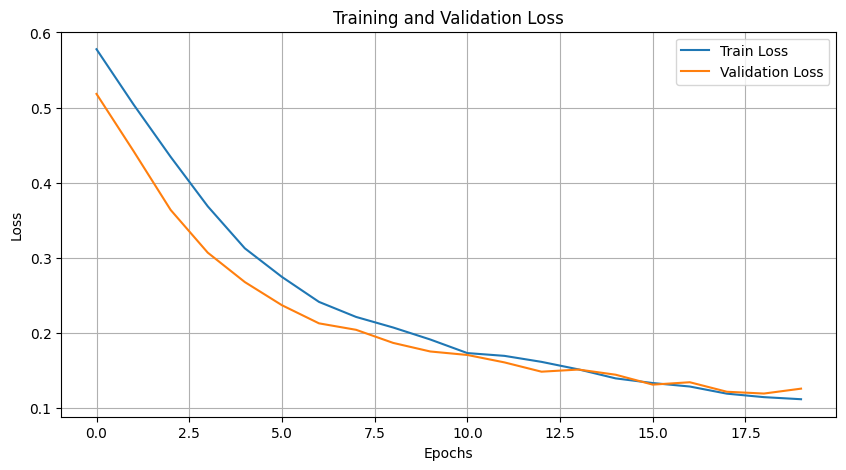

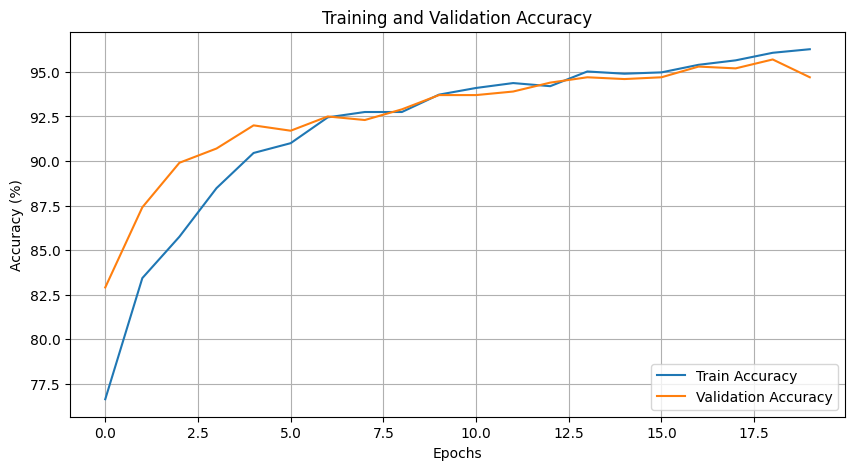

In [ ]:
# EfficientNet
from tqdm import tqdm

patience = 10  # 얼리 스탑 기준 (최대 10 에포크 동안 개선 없을 시 종료)
early_stop_counter = 0  # 성능 개선이 없을 때 증가


for i in range(num_epoch):
    # Train
    model.train()
    train_losses = []
    train_PROBS = []
    train_TARGETS = []
    start = time.time()

    # tqdm 라이브러리를 사용하여 학습 진행상황을 눈으로 볼수 있도록 하였습니다.
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {i} Train: ", total=len(train_loader))

    for k, (image, label) in enumerate(train_loader_tqdm):
        optimizer.zero_grad()
        image, label = image.to(device), label.to(device)
        logits = model(image)

        loss = loss_func(logits, label)

        probs = logits.softmax(1)

        loss.backward()
        optimizer.step()

        train_PROBS.append(probs.detach().cpu())
        train_TARGETS.append(label.detach().cpu())
        train_losses.append(loss.cpu().detach().numpy())

        # tqdm에 현재 loss를 표시
        train_loader_tqdm.set_postfix(loss=loss.item())

    train_PROBS = torch.cat(train_PROBS).numpy()
    train_TARGETS = torch.cat(train_TARGETS).numpy()
    train_ACC = (train_PROBS.argmax(1) == train_TARGETS).mean() * 100.

    # Evaluation
    model.eval()
    val_losses = []
    val_PROBS = []
    val_TARGETS = []

    # tqdm 라이브러리를 사용하여 검증 진행상황을 눈으로 볼수 있도록 하였습니다.
    validation_loader_tqdm = tqdm(validation_loader, desc=f"Epoch {i} Validation:", total=len(validation_loader))

    for k, (image, label) in enumerate(validation_loader_tqdm):
        with torch.no_grad():
            image, label = image.to(device), label.to(device)
            logits = model(image)
            loss = loss_func(logits, label)

            probs = logits.softmax(1)

            val_PROBS.append(probs.detach().cpu())
            val_TARGETS.append(label.detach().cpu())
            val_losses.append(loss.cpu().detach().numpy())

            # tqdm에 현재 validation loss 표시
            validation_loader_tqdm.set_postfix(loss=loss.item())

    val_PROBS = torch.cat(val_PROBS).numpy()
    val_TARGETS = torch.cat(val_TARGETS).numpy()
    val_ACC = (val_PROBS.argmax(1) == val_TARGETS).mean() * 100.

    tran_loss = np.array(train_losses).mean()
    val_loss = np.array(val_losses).mean()

    total_train_loss.append(tran_loss)
    total_val_loss.append(val_loss)

    total_train_ACC.append(train_ACC)
    total_val_ACC.append(val_ACC)
    end = time.time() - start
    print(f"Epoch: {str(i)}, Train loss: {tran_loss}, validation loss: {val_loss}, train ACC: {train_ACC}, val ACC: {val_ACC}, t: {end}s")

    # 러닝 스케줄러 업데이트
    scheduler.step(val_loss)  # validation loss를 기준으로 학습률 조정

    # 모델 저장
    if val_loss < best_loss:
        print("Save new param")
        torch.save(model, './param_' + str(i) + '.pt')
        best_loss = val_loss
        early_stop_counter = 0  # 성능 개선 시 초기화
    else:
        early_stop_counter += 1  # 개선되지 않을 때 증가

    # 얼리 스탑 조건 확인
    if early_stop_counter >= patience:
        print(f"Early stop {i}")
        break

# Loss 그래프
plt.figure(figsize=(10, 5))
plt.plot(total_train_loss, label='Train Loss')
plt.plot(total_val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Accuracy 그래프
plt.figure(figsize=(10, 5))
plt.plot(total_train_ACC, label='Train Accuracy')
plt.plot(total_val_ACC, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [ ]:
# VGG
from tqdm import tqdm

patience = 10  # 얼리 스탑 기준 (최대 10 에포크 동안 개선 없을 시 종료)
early_stop_counter = 0  # 성능 개선이 없을 때 증가


for i in range(num_epoch):
    # Train
    model.train()
    train_losses = []
    train_PROBS = []
    train_TARGETS = []
    start = time.time()

    # tqdm 라이브러리를 사용하여 학습 진행상황을 눈으로 볼수 있도록 하였습니다.
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {i} Train: ", total=len(train_loader))

    for k, (image, label) in enumerate(train_loader_tqdm):
        optimizer.zero_grad()
        image, label = image.to(device), label.to(device)
        logits = model(image)

        loss = loss_func(logits, label)

        probs = logits.softmax(1)

        loss.backward()
        optimizer.step()

        train_PROBS.append(probs.detach().cpu())
        train_TARGETS.append(label.detach().cpu())
        train_losses.append(loss.cpu().detach().numpy())

        # tqdm에 현재 loss를 표시
        train_loader_tqdm.set_postfix(loss=loss.item())

    train_PROBS = torch.cat(train_PROBS).numpy()
    train_TARGETS = torch.cat(train_TARGETS).numpy()
    train_ACC = (train_PROBS.argmax(1) == train_TARGETS).mean() * 100.

    # Evaluation
    model.eval()
    val_losses = []
    val_PROBS = []
    val_TARGETS = []

    # tqdm 라이브러리를 사용하여 검증 진행상황을 눈으로 볼수 있도록 하였습니다.
    validation_loader_tqdm = tqdm(validation_loader, desc=f"Epoch {i} Validation:", total=len(validation_loader))

    for k, (image, label) in enumerate(validation_loader_tqdm):
        with torch.no_grad():
            image, label = image.to(device), label.to(device)
            logits = model(image)
            loss = loss_func(logits, label)

            probs = logits.softmax(1)

            val_PROBS.append(probs.detach().cpu())
            val_TARGETS.append(label.detach().cpu())
            val_losses.append(loss.cpu().detach().numpy())

            # tqdm에 현재 validation loss 표시
            validation_loader_tqdm.set_postfix(loss=loss.item())

    val_PROBS = torch.cat(val_PROBS).numpy()
    val_TARGETS = torch.cat(val_TARGETS).numpy()
    val_ACC = (val_PROBS.argmax(1) == val_TARGETS).mean() * 100.

    tran_loss = np.array(train_losses).mean()
    val_loss = np.array(val_losses).mean()

    total_train_loss.append(tran_loss)
    total_val_loss.append(val_loss)

    total_train_ACC.append(train_ACC)
    total_val_ACC.append(val_ACC)
    end = time.time() - start
    print(f"Epoch: {str(i)}, Train loss: {tran_loss}, validation loss: {val_loss}, train ACC: {train_ACC}, val ACC: {val_ACC}, t: {end}s")

    # 러닝 스케줄러 업데이트
    scheduler.step(val_loss)  # validation loss를 기준으로 학습률 조정

    # 모델 저장
    if val_loss < best_loss:
        print("Save new param")
        torch.save(model, './param_' + str(i) + '.pt')
        best_loss = val_loss
        early_stop_counter = 0  # 성능 개선 시 초기화
    else:
        early_stop_counter += 1  # 개선되지 않을 때 증가

    # 얼리 스탑 조건 확인
    if early_stop_counter >= patience:
        print(f"Early stop {i}")
        break

Epoch 0 Validation:: 100%|██████████| 8/8 [01:59<00:00, 14.95s/it]


Epoch: 0, Train loss: 0.5572545528411865, validation loss: 0.3458610773086548, train ACC: 70.525, val ACC: 86.4, t: 590.1596274375916s
Save new param


Epoch 1 Validation:: 100%|██████████| 8/8 [00:05<00:00,  1.42it/s]


Epoch: 1, Train loss: 0.28952932357788086, validation loss: 0.2066737413406372, train ACC: 88.275, val ACC: 92.5, t: 28.38935947418213s
Save new param


Epoch 2 Validation:: 100%|██████████| 8/8 [00:05<00:00,  1.34it/s]


Epoch: 2, Train loss: 0.19806532561779022, validation loss: 0.1579206883907318, train ACC: 92.325, val ACC: 94.0, t: 29.106329679489136s
Save new param


Epoch 3 Validation:: 100%|██████████| 8/8 [00:05<00:00,  1.46it/s]


Epoch: 3, Train loss: 0.16115067899227142, validation loss: 0.14474686980247498, train ACC: 93.8, val ACC: 94.69999999999999, t: 28.86089539527893s
Save new param


Epoch 4 Validation:: 100%|██████████| 8/8 [00:05<00:00,  1.41it/s]


Epoch: 4, Train loss: 0.13438037037849426, validation loss: 0.12587900459766388, train ACC: 94.69999999999999, val ACC: 95.0, t: 28.970712661743164s
Save new param


Epoch 5 Validation:: 100%|██████████| 8/8 [00:05<00:00,  1.44it/s]


Epoch: 5, Train loss: 0.11734674870967865, validation loss: 0.09859028458595276, train ACC: 95.72500000000001, val ACC: 96.5, t: 28.226412057876587s
Save new param


Epoch 6 Validation:: 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Epoch: 6, Train loss: 0.10208046436309814, validation loss: 0.10029646009206772, train ACC: 96.575, val ACC: 95.6, t: 28.677624464035034s


Epoch 7 Validation:: 100%|██████████| 8/8 [00:05<00:00,  1.44it/s]


Epoch: 7, Train loss: 0.08792191743850708, validation loss: 0.10522548854351044, train ACC: 96.85000000000001, val ACC: 96.0, t: 27.184480905532837s


Epoch 8 Validation:: 100%|██████████| 8/8 [00:05<00:00,  1.49it/s]


Epoch: 8, Train loss: 0.07458847761154175, validation loss: 0.08171052485704422, train ACC: 97.39999999999999, val ACC: 96.5, t: 26.81483769416809s
Save new param


Epoch 9 Validation:: 100%|██████████| 8/8 [00:05<00:00,  1.41it/s]


Epoch: 9, Train loss: 0.06609702110290527, validation loss: 0.09022544324398041, train ACC: 97.775, val ACC: 96.39999999999999, t: 28.177725315093994s


Epoch 10 Validation:: 100%|██████████| 8/8 [00:05<00:00,  1.47it/s]


Epoch: 10, Train loss: 0.06931354105472565, validation loss: 0.08104745298624039, train ACC: 97.575, val ACC: 96.7, t: 26.724862337112427s
Save new param


Epoch 11 Validation:: 100%|██████████| 8/8 [00:05<00:00,  1.42it/s]


Epoch: 11, Train loss: 0.04750750958919525, validation loss: 0.07408162951469421, train ACC: 98.475, val ACC: 97.39999999999999, t: 28.26263403892517s
Save new param


Epoch 12 Validation:: 100%|██████████| 8/8 [00:05<00:00,  1.41it/s]


Epoch: 12, Train loss: 0.05108872428536415, validation loss: 0.09690915048122406, train ACC: 98.2, val ACC: 96.7, t: 28.911569118499756s


Epoch 13 Validation:: 100%|██████████| 8/8 [00:05<00:00,  1.45it/s]


Epoch: 13, Train loss: 0.03544851765036583, validation loss: 0.07412341237068176, train ACC: 98.8, val ACC: 96.89999999999999, t: 26.881272077560425s


Epoch 14 Validation:: 100%|██████████| 8/8 [00:05<00:00,  1.44it/s]


Epoch: 14, Train loss: 0.0389273539185524, validation loss: 0.06372541189193726, train ACC: 98.5, val ACC: 97.8, t: 27.010140895843506s
Save new param


Epoch 15 Validation:: 100%|██████████| 8/8 [00:05<00:00,  1.44it/s]


Epoch: 15, Train loss: 0.02826019562780857, validation loss: 0.07253815978765488, train ACC: 99.0, val ACC: 97.2, t: 28.10502052307129s


Epoch 16 Validation:: 100%|██████████| 8/8 [00:05<00:00,  1.48it/s]


Epoch: 16, Train loss: 0.03216930478811264, validation loss: 0.07815027236938477, train ACC: 98.775, val ACC: 97.1, t: 26.710710287094116s


Epoch 17 Validation:: 100%|██████████| 8/8 [00:05<00:00,  1.48it/s]


Epoch: 17, Train loss: 0.032179538160562515, validation loss: 0.0736306756734848, train ACC: 98.9, val ACC: 97.89999999999999, t: 26.980978965759277s


Epoch 18 Validation:: 100%|██████████| 8/8 [00:05<00:00,  1.43it/s]


Epoch: 18, Train loss: 0.03165171295404434, validation loss: 0.07048986107110977, train ACC: 98.75, val ACC: 97.6, t: 27.64814567565918s


Epoch 19 Validation:: 100%|██████████| 8/8 [00:05<00:00,  1.50it/s]

Epoch: 19, Train loss: 0.020603327080607414, validation loss: 0.07686734199523926, train ACC: 99.125, val ACC: 97.39999999999999, t: 27.170536041259766s


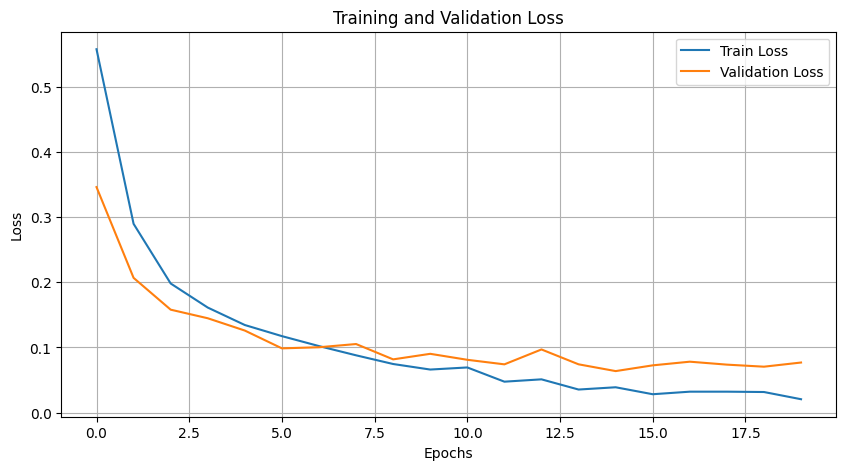

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(total_train_loss, label='Train Loss')
plt.plot(total_val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

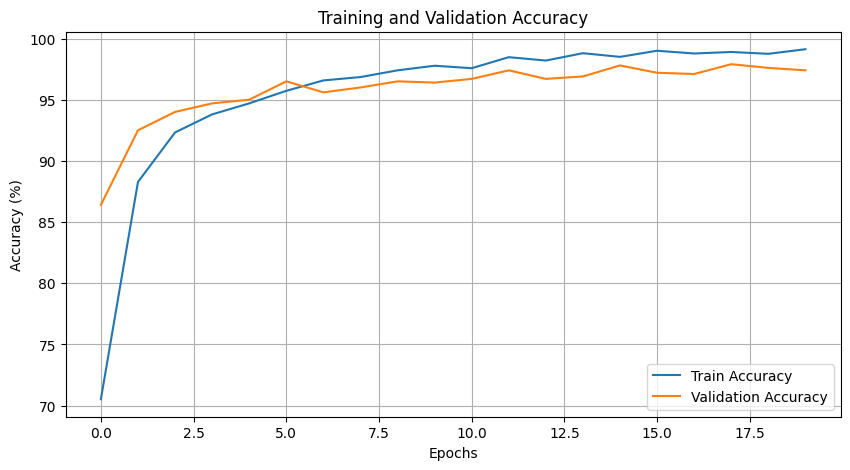

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(total_train_ACC, label='Train Accuracy')
plt.plot(total_val_ACC, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Epoch 0 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.41it/s, loss=1.72]


Epoch: 0, Train loss: 0.6245884895324707, validation loss: 3.4676918983459473, train ACC: 99.425, val ACC: 75.8, t: 20.108131170272827s


Epoch 1 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.44it/s, loss=4.44]


Epoch: 1, Train loss: 0.5854021906852722, validation loss: 3.088446617126465, train ACC: 99.5, val ACC: 80.4, t: 19.604747772216797s


Epoch 2 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.54it/s, loss=0.588]


Epoch: 2, Train loss: 0.5969594717025757, validation loss: 0.7302035093307495, train ACC: 99.4, val ACC: 85.8, t: 19.59000301361084s


Epoch 3 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.27it/s, loss=1.89]


Epoch: 3, Train loss: 0.6098891496658325, validation loss: 3.2628321647644043, train ACC: 99.1, val ACC: 78.60000000000001, t: 19.843381643295288s


Epoch 4 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.42it/s, loss=0.343]


Epoch: 4, Train loss: 0.5969613790512085, validation loss: 2.21061372756958, train ACC: 99.35000000000001, val ACC: 80.9, t: 19.67975687980652s


Epoch 5 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.52it/s, loss=3.08]


Epoch: 5, Train loss: 0.6150277853012085, validation loss: 1.8907997608184814, train ACC: 99.225, val ACC: 83.89999999999999, t: 19.655226945877075s


Epoch 6 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.59it/s, loss=1.97]


Epoch: 6, Train loss: 0.6097215414047241, validation loss: 1.9412014484405518, train ACC: 99.275, val ACC: 80.0, t: 19.504750728607178s


Epoch 7 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.23it/s, loss=0.992]


Epoch: 7, Train loss: 0.6110213994979858, validation loss: 1.1033649444580078, train ACC: 99.15, val ACC: 85.39999999999999, t: 19.820525884628296s


Epoch 8 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.47it/s, loss=0.107]


Epoch: 8, Train loss: 0.5914338231086731, validation loss: 0.6476026773452759, train ACC: 99.47500000000001, val ACC: 87.2, t: 19.54660177230835s


Epoch 9 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.26it/s, loss=1.97]


Epoch: 9, Train loss: 0.629142165184021, validation loss: 2.221590280532837, train ACC: 99.2, val ACC: 80.4, t: 19.732802867889404s
Early stopping triggered at epoch 9


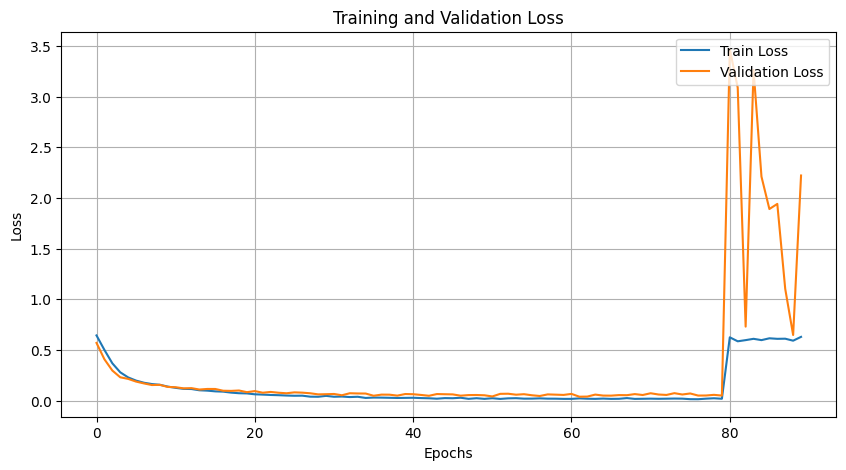

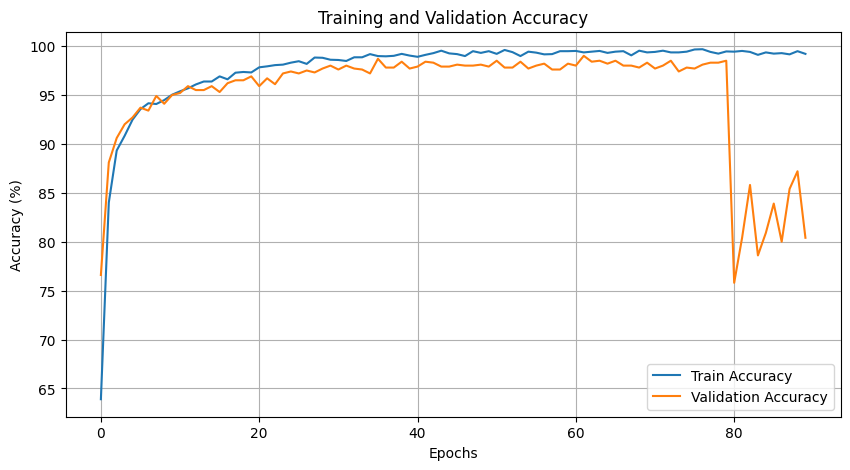

In [22]:
from tqdm import tqdm

patience = 10  # 얼리 스탑 기준 (최대 10 에포크 동안 개선 없을 시 종료)
early_stop_counter = 0  # 성능 개선이 없을 때 증가
epsilon = 0.01  # FGSM에서 최대 노이즈 perturbation 크기

# FGSM 어택
def FGSM_fun(model, input_data, target_label, epsilon):
    input_data.requires_grad = True # 그래디언트 계산
    output = model(input_data)  # 모델로 입력 데이터 예측
    loss = torch.nn.CrossEntropyLoss()(output, target_label)    # 예측값과 레이블을 비교하여 손실을 계산
    model.zero_grad()
    loss.backward()

    # FGSM으로 적대적 데이터 생성
    adversarial_data = input_data + epsilon * input_data.grad.sign()    # 개산된 그래디언트의 sign을 사용해서 입력데이터에 epsilon 크기의 노이즈 추가
    adversarial_data = torch.clamp(adversarial_data, 0, 1)  # 0 1 데이터 값 범위 유지
    return adversarial_data

for i in range(num_epoch):
    # Train
    model.train()
    train_losses = []
    train_PROBS = []
    train_TARGETS = []
    start = time.time()

    # tqdm 라이브러리를 사용하여 학습 진행상황을 눈으로 볼 수 있도록 설정
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {i} Train: ", total=len(train_loader))

    for k, (image, label) in enumerate(train_loader_tqdm):
        optimizer.zero_grad()
        image, label = image.to(device), label.to(device)

        # FGSM 적대적 예제 생성
        fgsm_image = FGSM_fun(model, image, label, epsilon)

        # 원본 데이터와 적대적 데이터 모두 사용
        original_logits = model(image)
        fgsm_logits = model(fgsm_image)

        # Loss 계산
        original_loss = loss_func(original_logits, label)
        fgsm_loss = loss_func(fgsm_logits, label)

        total_loss = original_loss + fgsm_loss

        # Backward 및 Optimizer Step
        total_loss.backward()
        optimizer.step()

        probs = original_logits.softmax(1)

        train_PROBS.append(probs.detach().cpu())
        train_TARGETS.append(label.detach().cpu())
        train_losses.append(total_loss.cpu().detach().numpy())

        # tqdm에 현재 loss를 표시
        train_loader_tqdm.set_postfix(loss=total_loss.item())

    train_PROBS = torch.cat(train_PROBS).numpy()
    train_TARGETS = torch.cat(train_TARGETS).numpy()
    train_ACC = (train_PROBS.argmax(1) == train_TARGETS).mean() * 100.

    # Evaluation
    model.eval()
    val_losses = []
    val_PROBS = []
    val_TARGETS = []

    # tqdm 라이브러리를 사용하여 검증 진행상황을 눈으로 볼 수 있도록 설정
    validation_loader_tqdm = tqdm(validation_loader, desc=f"Epoch {i} Validation:", total=len(validation_loader))

    for k, (image, label) in enumerate(validation_loader_tqdm):
        with torch.no_grad():
            image, label = image.to(device), label.to(device)
            logits = model(image)
            loss = loss_func(logits, label)

            probs = logits.softmax(1)

            val_PROBS.append(probs.detach().cpu())
            val_TARGETS.append(label.detach().cpu())
            val_losses.append(loss.cpu().detach().numpy())

            # tqdm에 현재 validation loss 표시
            validation_loader_tqdm.set_postfix(loss=loss.item())

    val_PROBS = torch.cat(val_PROBS).numpy()
    val_TARGETS = torch.cat(val_TARGETS).numpy()
    val_ACC = (val_PROBS.argmax(1) == val_TARGETS).mean() * 100.

    tran_loss = np.array(train_losses).mean()
    val_loss = np.array(val_losses).mean()

    total_train_loss.append(tran_loss)
    total_val_loss.append(val_loss)

    total_train_ACC.append(train_ACC)
    total_val_ACC.append(val_ACC)
    end = time.time() - start
    print(f"Epoch: {str(i)}, Train loss: {tran_loss}, validation loss: {val_loss}, train ACC: {train_ACC}, val ACC: {val_ACC}, t: {end}s")

    # 러닝 스케줄러 업데이트
    scheduler.step(val_loss)  # validation loss를 기준으로 학습률 조정

    # 모델 저장
    if val_loss < best_loss:
        print("Save new param")
        torch.save(model, './param_' + str(i) + '.pt')
        best_loss = val_loss
        early_stop_counter = 0  # 성능 개선 시 초기화
    else:
        early_stop_counter += 1  # 개선되지 않을 때 증가

    # 얼리 스탑 조건 확인
    if early_stop_counter >= patience:
        print(f"Early stopping triggered at epoch {i}")
        break

# Loss 그래프
plt.figure(figsize=(10, 5))
plt.plot(total_train_loss, label='Train Loss')
plt.plot(total_val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Accuracy 그래프
plt.figure(figsize=(10, 5))
plt.plot(total_train_ACC, label='Train Accuracy')
plt.plot(total_val_ACC, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [20]:
learning_rate = 0.00001
num_epoch = 80
best_loss = 100
total_train_loss = []
total_val_loss = []
total_train_ACC = []
total_val_ACC = []

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# StepLR 스케줄러 설정 (step_size는 학습률을 갱신할 주기, gamma는 감소 비율)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

Epoch 0 Validation:: 100%|██████████| 20/20 [00:48<00:00,  2.42s/it, loss=0.581]


Epoch: 0, Train loss: 0.6432994604110718, validation loss: 0.5692888498306274, train ACC: 63.9, val ACC: 76.6, t: 228.1782829761505s
Save new param


Epoch 1 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.16it/s, loss=0.43]


Epoch: 1, Train loss: 0.500296950340271, validation loss: 0.40795832872390747, train ACC: 84.0, val ACC: 88.1, t: 17.852982759475708s
Save new param


Epoch 2 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.52it/s, loss=0.309]


Epoch: 2, Train loss: 0.36824163794517517, validation loss: 0.2968445420265198, train ACC: 89.325, val ACC: 90.60000000000001, t: 17.435818195343018s
Save new param


Epoch 3 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.37it/s, loss=0.193]


Epoch: 3, Train loss: 0.27932220697402954, validation loss: 0.23020601272583008, train ACC: 90.825, val ACC: 92.0, t: 17.49931049346924s
Save new param


Epoch 4 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.30it/s, loss=0.191]


Epoch: 4, Train loss: 0.2289077788591385, validation loss: 0.2143988311290741, train ACC: 92.475, val ACC: 92.7, t: 17.564836025238037s
Save new param


Epoch 5 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.41it/s, loss=0.172]


Epoch: 5, Train loss: 0.19738070666790009, validation loss: 0.187668576836586, train ACC: 93.55, val ACC: 93.7, t: 17.432944774627686s
Save new param


Epoch 6 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.37it/s, loss=0.139]


Epoch: 6, Train loss: 0.17640110850334167, validation loss: 0.16956281661987305, train ACC: 94.15, val ACC: 93.4, t: 17.449145555496216s
Save new param


Epoch 7 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.47it/s, loss=0.141]


Epoch: 7, Train loss: 0.16337434947490692, validation loss: 0.15373875200748444, train ACC: 94.075, val ACC: 94.89999999999999, t: 17.319137573242188s
Save new param


Epoch 8 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.20it/s, loss=0.118]


Epoch: 8, Train loss: 0.15629562735557556, validation loss: 0.1557660698890686, train ACC: 94.475, val ACC: 94.1, t: 17.55816650390625s


Epoch 9 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.47it/s, loss=0.112]


Epoch: 9, Train loss: 0.13842718303203583, validation loss: 0.13499236106872559, train ACC: 95.025, val ACC: 95.0, t: 17.265141010284424s
Save new param


Epoch 10 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.46it/s, loss=0.104]


Epoch: 10, Train loss: 0.12607218325138092, validation loss: 0.1321059763431549, train ACC: 95.375, val ACC: 95.19999999999999, t: 17.364444971084595s
Save new param


Epoch 11 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.37it/s, loss=0.0799]


Epoch: 11, Train loss: 0.11598572880029678, validation loss: 0.12097059190273285, train ACC: 95.675, val ACC: 95.89999999999999, t: 17.526177406311035s
Save new param


Epoch 12 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.34it/s, loss=0.0736]


Epoch: 12, Train loss: 0.11437328159809113, validation loss: 0.12322346866130829, train ACC: 96.075, val ACC: 95.5, t: 17.54673981666565s


Epoch 13 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.66it/s, loss=0.0759]


Epoch: 13, Train loss: 0.10199862718582153, validation loss: 0.10930626094341278, train ACC: 96.375, val ACC: 95.5, t: 17.181103467941284s
Save new param


Epoch 14 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.58it/s, loss=0.0857]


Epoch: 14, Train loss: 0.09840299189090729, validation loss: 0.11511419713497162, train ACC: 96.375, val ACC: 95.89999999999999, t: 17.17244267463684s


Epoch 15 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.27it/s, loss=0.0673]


Epoch: 15, Train loss: 0.09139303863048553, validation loss: 0.1148051768541336, train ACC: 96.89999999999999, val ACC: 95.3, t: 17.451690435409546s


Epoch 16 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.45it/s, loss=0.059]


Epoch: 16, Train loss: 0.08866145461797714, validation loss: 0.09750448912382126, train ACC: 96.6, val ACC: 96.2, t: 17.207241773605347s
Save new param


Epoch 17 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.53it/s, loss=0.0477]


Epoch: 17, Train loss: 0.07885201275348663, validation loss: 0.09594108164310455, train ACC: 97.275, val ACC: 96.5, t: 17.19074249267578s
Save new param


Epoch 18 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.44it/s, loss=0.0369]


Epoch: 18, Train loss: 0.0729769915342331, validation loss: 0.09983173757791519, train ACC: 97.35000000000001, val ACC: 96.5, t: 17.409837245941162s


Epoch 19 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.31it/s, loss=0.0459]


Epoch: 19, Train loss: 0.07105238735675812, validation loss: 0.08336107432842255, train ACC: 97.3, val ACC: 96.89999999999999, t: 17.818100690841675s
Save new param


Epoch 20 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.56it/s, loss=0.0338]


Epoch: 20, Train loss: 0.062393419444561005, validation loss: 0.09402403980493546, train ACC: 97.82499999999999, val ACC: 95.89999999999999, t: 17.294897317886353s


Epoch 21 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.39it/s, loss=0.0392]


Epoch: 21, Train loss: 0.059304989874362946, validation loss: 0.07788954675197601, train ACC: 97.925, val ACC: 96.7, t: 17.875374794006348s
Save new param


Epoch 22 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.21it/s, loss=0.0663]


Epoch: 22, Train loss: 0.055755794048309326, validation loss: 0.08573819696903229, train ACC: 98.05, val ACC: 96.1, t: 17.940474271774292s


Epoch 23 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.70it/s, loss=0.0108]


Epoch: 23, Train loss: 0.05347204953432083, validation loss: 0.07771246135234833, train ACC: 98.1, val ACC: 97.2, t: 17.345985174179077s
Save new param


Epoch 24 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.24it/s, loss=0.021]


Epoch: 24, Train loss: 0.05012301728129387, validation loss: 0.07264705002307892, train ACC: 98.3, val ACC: 97.39999999999999, t: 17.850958347320557s
Save new param


Epoch 25 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.19it/s, loss=0.0456]


Epoch: 25, Train loss: 0.047904059290885925, validation loss: 0.08138714730739594, train ACC: 98.45, val ACC: 97.2, t: 18.019943475723267s


Epoch 26 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.46it/s, loss=0.0144]


Epoch: 26, Train loss: 0.04874911904335022, validation loss: 0.07854114472866058, train ACC: 98.175, val ACC: 97.5, t: 17.49116849899292s


Epoch 27 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.45it/s, loss=0.0355]


Epoch: 27, Train loss: 0.038926396518945694, validation loss: 0.07245262712240219, train ACC: 98.825, val ACC: 97.3, t: 17.48403310775757s
Save new param


Epoch 28 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.25it/s, loss=0.0372]


Epoch: 28, Train loss: 0.03803092613816261, validation loss: 0.06158202141523361, train ACC: 98.8, val ACC: 97.7, t: 18.18106985092163s
Save new param


Epoch 29 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.24it/s, loss=0.0144]


Epoch: 29, Train loss: 0.04685837775468826, validation loss: 0.06327736377716064, train ACC: 98.6, val ACC: 98.0, t: 18.166738271713257s


Epoch 30 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.17it/s, loss=0.0419]


Epoch: 30, Train loss: 0.03817065805196762, validation loss: 0.06558863818645477, train ACC: 98.575, val ACC: 97.6, t: 17.909489154815674s


Epoch 31 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.17it/s, loss=0.0368]


Epoch: 31, Train loss: 0.040300603955984116, validation loss: 0.05287536233663559, train ACC: 98.475, val ACC: 98.0, t: 17.935161113739014s
Save new param


Epoch 32 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.24it/s, loss=0.0104]


Epoch: 32, Train loss: 0.035140376538038254, validation loss: 0.07272178679704666, train ACC: 98.85000000000001, val ACC: 97.7, t: 17.66783308982849s


Epoch 33 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.46it/s, loss=0.031]


Epoch: 33, Train loss: 0.03797438368201256, validation loss: 0.07054390013217926, train ACC: 98.85000000000001, val ACC: 97.6, t: 17.3443386554718s


Epoch 34 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.50it/s, loss=0.013]


Epoch: 34, Train loss: 0.026407212018966675, validation loss: 0.06982054561376572, train ACC: 99.175, val ACC: 97.2, t: 17.2381010055542s


Epoch 35 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.26it/s, loss=0.00378]


Epoch: 35, Train loss: 0.030080219730734825, validation loss: 0.04810532182455063, train ACC: 98.97500000000001, val ACC: 98.7, t: 17.626600742340088s
Save new param


Epoch 36 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.66it/s, loss=0.011]


Epoch: 36, Train loss: 0.029455173760652542, validation loss: 0.05913616344332695, train ACC: 98.95, val ACC: 97.8, t: 17.495664596557617s


Epoch 37 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.41it/s, loss=0.0284]


Epoch: 37, Train loss: 0.027805933728814125, validation loss: 0.058702968060970306, train ACC: 99.0, val ACC: 97.8, t: 17.4522647857666s


Epoch 38 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.31it/s, loss=0.0169]


Epoch: 38, Train loss: 0.026206493377685547, validation loss: 0.04929349943995476, train ACC: 99.2, val ACC: 98.4, t: 17.52514672279358s


Epoch 39 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.28it/s, loss=0.0157]


Epoch: 39, Train loss: 0.027092397212982178, validation loss: 0.06504087150096893, train ACC: 99.02499999999999, val ACC: 97.7, t: 17.607975482940674s


Epoch 40 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.48it/s, loss=0.0282]


Epoch: 40, Train loss: 0.028193211182951927, validation loss: 0.06318757683038712, train ACC: 98.9, val ACC: 97.89999999999999, t: 17.305713415145874s


Epoch 41 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.53it/s, loss=0.00379]


Epoch: 41, Train loss: 0.025057965889573097, validation loss: 0.05594548583030701, train ACC: 99.1, val ACC: 98.4, t: 17.349499464035034s


Epoch 42 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.17it/s, loss=0.00922]


Epoch: 42, Train loss: 0.023178592324256897, validation loss: 0.047707449644804, train ACC: 99.275, val ACC: 98.3, t: 17.539745569229126s
Save new param


Epoch 43 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.68it/s, loss=0.0122]


Epoch: 43, Train loss: 0.01898861676454544, validation loss: 0.06476512551307678, train ACC: 99.52499999999999, val ACC: 97.89999999999999, t: 17.107656240463257s


Epoch 44 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.44it/s, loss=0.012]


Epoch: 44, Train loss: 0.02481725439429283, validation loss: 0.06298895925283432, train ACC: 99.25, val ACC: 97.89999999999999, t: 17.199636459350586s


Epoch 45 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.24it/s, loss=0.0121]


Epoch: 45, Train loss: 0.02356318011879921, validation loss: 0.061357807368040085, train ACC: 99.175, val ACC: 98.1, t: 17.827471494674683s


Epoch 46 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.12it/s, loss=0.0155]


Epoch: 46, Train loss: 0.028323238715529442, validation loss: 0.04872686415910721, train ACC: 98.97500000000001, val ACC: 98.0, t: 17.912806272506714s


Epoch 47 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.43it/s, loss=0.0155]


Epoch: 47, Train loss: 0.017586199566721916, validation loss: 0.05465271323919296, train ACC: 99.47500000000001, val ACC: 98.0, t: 17.76088047027588s


Epoch 48 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.38it/s, loss=0.0106]


Epoch: 48, Train loss: 0.02376246079802513, validation loss: 0.055423397570848465, train ACC: 99.3, val ACC: 98.1, t: 17.79108715057373s


Epoch 49 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.10it/s, loss=0.0102]


Epoch: 49, Train loss: 0.017497120425105095, validation loss: 0.05272746831178665, train ACC: 99.47500000000001, val ACC: 97.89999999999999, t: 17.82636308670044s


Epoch 50 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.55it/s, loss=0.00433]


Epoch: 50, Train loss: 0.023518724367022514, validation loss: 0.04113883152604103, train ACC: 99.2, val ACC: 98.5, t: 17.6578106880188s
Save new param


Epoch 51 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.58it/s, loss=0.0038]


Epoch: 51, Train loss: 0.016759498044848442, validation loss: 0.06679996103048325, train ACC: 99.6, val ACC: 97.8, t: 17.4441876411438s


Epoch 52 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.50it/s, loss=0.00986]


Epoch: 52, Train loss: 0.02234479784965515, validation loss: 0.06795816868543625, train ACC: 99.375, val ACC: 97.8, t: 17.228273630142212s


Epoch 53 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.45it/s, loss=0.00434]


Epoch: 53, Train loss: 0.02401997521519661, validation loss: 0.058450646698474884, train ACC: 98.97500000000001, val ACC: 98.4, t: 17.263810873031616s


Epoch 54 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.52it/s, loss=0.0232]


Epoch: 54, Train loss: 0.01943514309823513, validation loss: 0.06337903439998627, train ACC: 99.425, val ACC: 97.7, t: 17.513209104537964s


Epoch 55 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.54it/s, loss=0.00703]


Epoch: 55, Train loss: 0.019688164815306664, validation loss: 0.052824966609478, train ACC: 99.325, val ACC: 98.0, t: 17.25168228149414s


Epoch 56 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.40it/s, loss=0.00769]


Epoch: 56, Train loss: 0.02227228879928589, validation loss: 0.04572785273194313, train ACC: 99.15, val ACC: 98.2, t: 17.178415775299072s


Epoch 57 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.51it/s, loss=0.0314]


Epoch: 57, Train loss: 0.019375918433070183, validation loss: 0.06144490838050842, train ACC: 99.175, val ACC: 97.6, t: 17.261690616607666s


Epoch 58 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.47it/s, loss=0.0317]


Epoch: 58, Train loss: 0.01909787580370903, validation loss: 0.05878972262144089, train ACC: 99.47500000000001, val ACC: 97.6, t: 17.18059754371643s


Epoch 59 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.52it/s, loss=0.0042]


Epoch: 59, Train loss: 0.01723415218293667, validation loss: 0.05619344115257263, train ACC: 99.47500000000001, val ACC: 98.2, t: 17.217687606811523s


Epoch 60 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.31it/s, loss=0.00694]


Epoch: 60, Train loss: 0.01721605472266674, validation loss: 0.06629204005002975, train ACC: 99.5, val ACC: 98.0, t: 17.23107647895813s


Epoch 61 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.60it/s, loss=0.012]


Epoch: 61, Train loss: 0.02200097031891346, validation loss: 0.03866026550531387, train ACC: 99.35000000000001, val ACC: 99.0, t: 17.279308557510376s
Save new param


Epoch 62 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.61it/s, loss=0.00507]


Epoch: 62, Train loss: 0.018668117001652718, validation loss: 0.03988402336835861, train ACC: 99.425, val ACC: 98.4, t: 16.943048000335693s


Epoch 63 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.40it/s, loss=0.0104]


Epoch: 63, Train loss: 0.017292693257331848, validation loss: 0.0594029426574707, train ACC: 99.5, val ACC: 98.5, t: 17.495083808898926s


Epoch 64 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.26it/s, loss=0.027]


Epoch: 64, Train loss: 0.020168352872133255, validation loss: 0.04979623109102249, train ACC: 99.3, val ACC: 98.2, t: 17.587185859680176s


Epoch 65 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.50it/s, loss=0.017]


Epoch: 65, Train loss: 0.017179053276777267, validation loss: 0.04910134896636009, train ACC: 99.425, val ACC: 98.5, t: 17.334083080291748s


Epoch 66 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.49it/s, loss=0.013]


Epoch: 66, Train loss: 0.017997561022639275, validation loss: 0.0545729324221611, train ACC: 99.47500000000001, val ACC: 98.0, t: 17.394270420074463s


Epoch 67 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.45it/s, loss=0.00612]


Epoch: 67, Train loss: 0.024911079555749893, validation loss: 0.05360613018274307, train ACC: 99.05000000000001, val ACC: 98.0, t: 17.17521023750305s


Epoch 68 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.58it/s, loss=0.0155]


Epoch: 68, Train loss: 0.01701398193836212, validation loss: 0.06427793204784393, train ACC: 99.52499999999999, val ACC: 97.8, t: 17.515963315963745s


Epoch 69 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.58it/s, loss=0.0469]


Epoch: 69, Train loss: 0.018154095858335495, validation loss: 0.05540188029408455, train ACC: 99.35000000000001, val ACC: 98.3, t: 17.096115112304688s


Epoch 70 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.52it/s, loss=0.0118]


Epoch: 70, Train loss: 0.019345130771398544, validation loss: 0.07263888418674469, train ACC: 99.4, val ACC: 97.7, t: 17.24174952507019s


Epoch 71 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.16it/s, loss=0.0136]


Epoch: 71, Train loss: 0.017972949892282486, validation loss: 0.060275424271821976, train ACC: 99.52499999999999, val ACC: 98.0, t: 17.37580704689026s


Epoch 72 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.50it/s, loss=0.0078]


Epoch: 72, Train loss: 0.019144374877214432, validation loss: 0.05603663995862007, train ACC: 99.35000000000001, val ACC: 98.5, t: 17.331604719161987s


Epoch 73 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.54it/s, loss=0.00269]


Epoch: 73, Train loss: 0.020312044769525528, validation loss: 0.07348401844501495, train ACC: 99.35000000000001, val ACC: 97.39999999999999, t: 17.19036054611206s


Epoch 74 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.49it/s, loss=0.0019]


Epoch: 74, Train loss: 0.019428756088018417, validation loss: 0.0603506863117218, train ACC: 99.425, val ACC: 97.8, t: 17.185680866241455s


Epoch 75 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.19it/s, loss=0.0184]


Epoch: 75, Train loss: 0.014229374006390572, validation loss: 0.07056297361850739, train ACC: 99.65, val ACC: 97.7, t: 17.39827275276184s


Epoch 76 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.57it/s, loss=0.00426]


Epoch: 76, Train loss: 0.013768662698566914, validation loss: 0.0499129593372345, train ACC: 99.675, val ACC: 98.1, t: 16.893657445907593s


Epoch 77 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.62it/s, loss=0.0128]


Epoch: 77, Train loss: 0.019336357712745667, validation loss: 0.05055858939886093, train ACC: 99.4, val ACC: 98.3, t: 17.301442861557007s


Epoch 78 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.31it/s, loss=0.0122]


Epoch: 78, Train loss: 0.023117907345294952, validation loss: 0.056969739496707916, train ACC: 99.225, val ACC: 98.3, t: 17.3803551197052s


Epoch 79 Validation:: 100%|██████████| 20/20 [00:03<00:00,  5.52it/s, loss=0.0123]


Epoch: 79, Train loss: 0.01844014786183834, validation loss: 0.04969064146280289, train ACC: 99.45, val ACC: 98.5, t: 17.158479690551758s


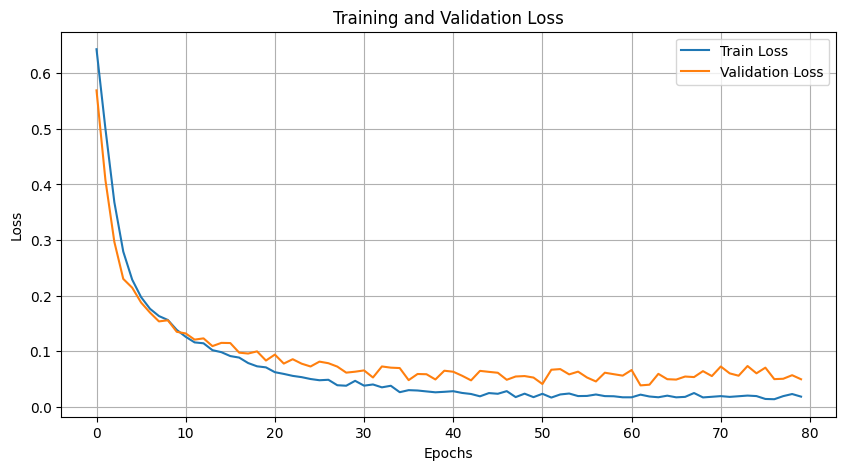

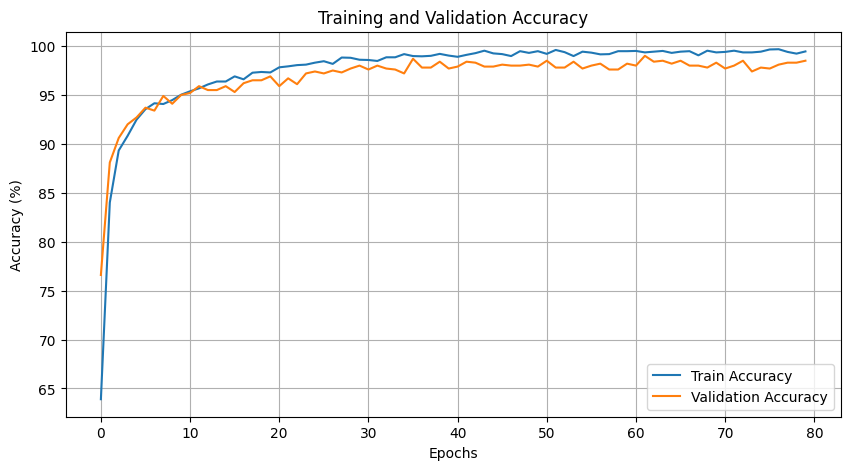

In [21]:
# EfficientNet 추가학습
from tqdm import tqdm

patience = 20  # 얼리 스탑 기준 (최대 10 에포크 동안 개선 없을 시 종료)
early_stop_counter = 0  # 성능 개선이 없을 때 증가


for i in range(num_epoch):
    # Train
    model.train()
    train_losses = []
    train_PROBS = []
    train_TARGETS = []
    start = time.time()

    # tqdm 라이브러리를 사용하여 학습 진행상황을 눈으로 볼수 있도록 하였습니다.
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {i} Train: ", total=len(train_loader))

    for k, (image, label) in enumerate(train_loader_tqdm):
        optimizer.zero_grad()
        image, label = image.to(device), label.to(device)
        logits = model(image)

        loss = loss_func(logits, label)

        probs = logits.softmax(1)

        loss.backward()
        optimizer.step()

        train_PROBS.append(probs.detach().cpu())
        train_TARGETS.append(label.detach().cpu())
        train_losses.append(loss.cpu().detach().numpy())

        # tqdm에 현재 loss를 표시
        train_loader_tqdm.set_postfix(loss=loss.item())

    train_PROBS = torch.cat(train_PROBS).numpy()
    train_TARGETS = torch.cat(train_TARGETS).numpy()
    train_ACC = (train_PROBS.argmax(1) == train_TARGETS).mean() * 100.

    # Evaluation
    model.eval()
    val_losses = []
    val_PROBS = []
    val_TARGETS = []

    # tqdm 라이브러리를 사용하여 검증 진행상황을 눈으로 볼수 있도록 하였습니다.
    validation_loader_tqdm = tqdm(validation_loader, desc=f"Epoch {i} Validation:", total=len(validation_loader))

    for k, (image, label) in enumerate(validation_loader_tqdm):
        with torch.no_grad():
            image, label = image.to(device), label.to(device)
            logits = model(image)
            loss = loss_func(logits, label)

            probs = logits.softmax(1)

            val_PROBS.append(probs.detach().cpu())
            val_TARGETS.append(label.detach().cpu())
            val_losses.append(loss.cpu().detach().numpy())

            # tqdm에 현재 validation loss 표시
            validation_loader_tqdm.set_postfix(loss=loss.item())

    val_PROBS = torch.cat(val_PROBS).numpy()
    val_TARGETS = torch.cat(val_TARGETS).numpy()
    val_ACC = (val_PROBS.argmax(1) == val_TARGETS).mean() * 100.

    tran_loss = np.array(train_losses).mean()
    val_loss = np.array(val_losses).mean()

    total_train_loss.append(tran_loss)
    total_val_loss.append(val_loss)

    total_train_ACC.append(train_ACC)
    total_val_ACC.append(val_ACC)
    end = time.time() - start
    print(f"Epoch: {str(i)}, Train loss: {tran_loss}, validation loss: {val_loss}, train ACC: {train_ACC}, val ACC: {val_ACC}, t: {end}s")

    # 러닝 스케줄러 업데이트
    scheduler.step(val_loss)  # validation loss를 기준으로 학습률 조정

    # 모델 저장
    if val_loss < best_loss:
        print("Save new param")
        torch.save(model, './param_' + str(i) + '.pt')
        best_loss = val_loss
        early_stop_counter = 0  # 성능 개선 시 초기화
    else:
        early_stop_counter += 1  # 개선되지 않을 때 증가

    # 얼리 스탑 조건 확인
    if early_stop_counter >= patience:
        print(f"Early stop {i}")
        break

# Loss 그래프
plt.figure(figsize=(10, 5))
plt.plot(total_train_loss, label='Train Loss')
plt.plot(total_val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Accuracy 그래프
plt.figure(figsize=(10, 5))
plt.plot(total_train_ACC, label='Train Accuracy')
plt.plot(total_val_ACC, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [17]:
# Kaggle 이외의 환경에서 사용
# file_path = '데이터셋_경로/test/*.jpg'
file_path = '/content/drive/MyDrive/data/ipdl/test/*.jpg'

file_list = glob(file_path)
data_dict = {'image_name':[], 'file_path':[]}

for path in file_list:
    data_dict['file_path'].append(path) # file_path 항목에 파일 경로 저장
    path_list = path.split(os.path.sep) # os별 파일 경로 구분 문자로 split
    data_dict['image_name'].append(path_list[-1])


train_df = pd.DataFrame(data_dict)
print('\n<data frame>\n', train_df)

train_df.to_csv("./test.csv", mode='w')


<data frame>
         image_name                                          file_path
0     uvbwoxex.jpg  /content/drive/MyDrive/data/ipdl/test/uvbwoxex...
1     uvcsqqkj.jpg  /content/drive/MyDrive/data/ipdl/test/uvcsqqkj...
2     uvddmpwu.jpg  /content/drive/MyDrive/data/ipdl/test/uvddmpwu...
3       uvgilc.jpg   /content/drive/MyDrive/data/ipdl/test/uvgilc.jpg
4       uvguhv.jpg   /content/drive/MyDrive/data/ipdl/test/uvguhv.jpg
...            ...                                                ...
4995    feznbh.jpg   /content/drive/MyDrive/data/ipdl/test/feznbh.jpg
4996     ffdby.jpg    /content/drive/MyDrive/data/ipdl/test/ffdby.jpg
4997  ffegwsnw.jpg  /content/drive/MyDrive/data/ipdl/test/ffegwsnw...
4998  ffihhrvw.jpg  /content/drive/MyDrive/data/ipdl/test/ffihhrvw...
4999    ffkkvg.jpg   /content/drive/MyDrive/data/ipdl/test/ffkkvg.jpg

[5000 rows x 2 columns]


In [18]:
num_workers = 0
batch_size = 1

test_dataset = MMC_ClassificationDataset("./test.csv", 'test', transform = transforms_val)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 1, num_workers = num_workers, shuffle = False, drop_last = False)

In [19]:
# GPU 사용 설정
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    device = 'cpu'
    print('CUDA is not available.  Training on CPU ...')
else:
    device = 'cuda'
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [19]:
# 모델 불러오기
# model = torch.load("C:/sg0117/hallym/Image_processing/save_data/param_9.pt").to(device)
# model = torch.load("C:/sg0117/hallym/Image_processing/save_data/param_9.pt", weights_only=False).to(device)
# model = torch.load("C:/sg0117/hallym/Image_processing/save_data/EfficienNet_learning_scheduler/param_41.pt", weights_only=False).to(device)
# model = torch.load("C:/sg0117/hallym/Image_processing/save_data/EfficienNet/param_7.pt", weights_only=False).to(device)
# model = torch.load("C:/sg0117/hallym/Image_processing/save_data/ViT_learning_scheduler/param_28._ViT_241210_1958pt.pt", weights_only=False).to(device)
# model = torch.load("C:/sg0117/hallym/Image_processing/save_data/efficientnet_v2_s/param_2.pt", weights_only=False).to(device)
# model = torch.load("C:/sg0117/hallym/Image_processing/save_data/VGG/vgg_best_loss_param_14.pt", weights_only=False).to(device)
# model = torch.load("/content/best_loss_param_2.pt", weights_only=False).to(device)
model = torch.load("/content/efficientNet_추가학습_param_57.pt", weights_only=False).to(device)

ids = []
targets = []
model.eval()
for k ,(image, image_id) in enumerate(test_loader):
    with torch.no_grad():
        output = model.forward(image.to(device))
        target = output.argmax(1).item()
        ids.append(image_id[0])
        targets.append(target)

In [31]:
submission = pd.DataFrame({'ID': ids, 'label': targets})

In [32]:
submission.to_csv('./sample_submission_model_ensemble.csv',index = False)

In [ ]:
# model ensemble 등 다양한 기법 사용

In [29]:
# 모델 불러오기

model_path = [
    '/content/model/efficentNet_learining_param_41.pt',
    '/content/model/efficentNet_param_7.pt',
    '/content/model/param_28_ViT_241210_1958.pt',
    '/content/model/vgg_best_loss_param_14.pt',]

ids = []
targets = []

for k ,(image, image_id) in enumerate(test_loader):
    with torch.no_grad():
        ensemble_output = []
        for m_path in model_path:
            # 모데 불러오기
            model = torch.load(m_path, weights_only=False).to(device)
            model.eval()

            output = model.forward(image.to(device))
            ensemble_output.append(output)

        # 확률 평균 계산함
        avg_output = sum(ensemble_output) / len(ensemble_output)
        target = avg_output.argmax(1).item()

        ids.append(image_id[0])
        targets.append(target)

In [ ]:
submission = pd.DataFrame({'ID': ids, 'label': targets})
submission.to_csv('./sample_submission_model_ensemble.csv',index = False)

In [ ]:
# 입력 데이터의 transform을 이용한 앙상블 예제
num_workers = 0
batch_size = 1

# 원본 이미지
transforms_val_2 = albumentations.Compose([
        albumentations.Resize(224, 224),
        albumentations.Normalize()
])

# 좌우 반전 이미지
transforms_val_1 = albumentations.Compose([
        albumentations.HorizontalFlip(p=1),
        albumentations.Resize(224, 224),
        albumentations.Normalize()
])


test_dataset_1 = MMC_ClassificationDataset('/kaggle/input/ipdl-2024/test.csv', 'test', transform = transforms_val_1)
test_loader_1 = torch.utils.data.DataLoader(test_dataset_1, batch_size = 1, num_workers = num_workers, shuffle = False, drop_last = False)

test_dataset_2 = MMC_ClassificationDataset('/kaggle/input/ipdl-2024/test.csv', 'test', transform = transforms_val_2)
test_loader_2 = torch.utils.data.DataLoader(test_dataset_2, batch_size = 1, num_workers = num_workers, shuffle = False, drop_last = False)

In [ ]:
# 원본 이미지 이미지를 모델의 입력으로 주어 확률 분포를 얻음
ids_1 = []
outputs_1 = []
model.eval()
for k ,(image, image_id) in enumerate(test_loader_1):
    with torch.no_grad():
        output = model.forward(image.to(device))
        target = output.argmax(1).item()
        ids_1.append(image_id[0])
        outputs_1.append(output)
        break

In [ ]:
# 좌우 반전 이미지를 모델의 입력으로 주어 확률 분포를 얻음
ids_2 = []
outputs_2 = []
model.eval()
for k ,(image, image_id) in enumerate(test_loader_2):
    with torch.no_grad():
        output = model.forward(image.to(device))
        target = output.argmax(1).item()
        ids_2.append(image_id[0])
        outputs_2.append(output)
        break

In [ ]:
targets = []
for i in range(len(ids_1)):
    if ids_1[i] == ids_2[i]:
        # 확률 분포를 평균내어 최종 결과로 사용 (voting을 사용해도 됨)
        output = (outputs_1[i] + outputs_2[i]) / 2
        target = output.argmax(1).item()
        targets.append(target)

In [ ]:
targets

[0]